In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
#import data

df = pd.read_csv('merged_cleaned.csv', names=["time", "load", "price", "biomass", "water", "offshore", "onshore", "solar", "other_renewable", "nuclear", "lignite", "coal", "gas", "pumped", "other_conv", "holiday", "date", "hour", "dayofweek", "day_name", "quarter", "month", "year", "dayofyear", "dayofmonth", "date_offset", "hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos", "month_sin", "month_cos", "dayofyear_sin", "dayofyear_cos", "is_workday"], header=0)

#adapt column "holiday", so only 0 for Not a Holiday and 1 for any holidays is used
df["holiday"] = df["holiday"].apply(lambda x: 0 if x == "Not a Holiday" else 1)

# Convert 'time' to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Inspect the first few rows of the data
print(df.head())

                         load  price  biomass    water  offshore   onshore  \
time                                                                         
2018-11-01 00:00:00  48879.50  40.86  4754.75  1583.00   2721.00  11628.50   
2018-11-01 01:00:00  47312.50  41.10  4741.25  1587.50   2678.00  11029.00   
2018-11-01 02:00:00  46093.75  40.59  4733.25  1567.50   2836.75  11025.00   
2018-11-01 03:00:00  46710.50  40.09  4725.25  1550.00   2968.50  10480.25   
2018-11-01 04:00:00  47624.25  39.11  4715.00  1535.75   2765.25  10871.25   

                     solar  other_renewable  nuclear   lignite  ...  \
time                                                            ...   
2018-11-01 00:00:00    0.0           153.00   7933.0  16108.75  ...   
2018-11-01 01:00:00    0.0           153.00   7933.5  16119.00  ...   
2018-11-01 02:00:00    0.0           153.00   7927.0  16111.00  ...   
2018-11-01 03:00:00    0.0           152.50   7930.5  16134.75  ...   
2018-11-01 04:00:00    0.0 

# Normalize time series

In [3]:
#Normalization lead to worse results

#mean = df['load'].mean()
#std = df['load'].std()
#df['load'] = (df['load'] - mean) / std

## Train / Test split

In [4]:
# Check for the range of the data to verify the time span
print(df.index.min(), df.index.max())  # Should show range from Nov 1st, 2018 to Oct 31st, 2024

# Split the data into training and test sets (5:1 years)
train_size = int(0.83296 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]


2018-11-01 00:00:00 2024-10-30 23:00:00


## Fourier Transform

In [5]:
from numpy.fft import fft, fftfreq

# Perform FFT on "load" column
energy_load = train['load']  
n = len(energy_load)
spectrum = np.fft.fft(energy_load)
freqs = fftfreq(n, d=1)  # Adjust d for the time difference between entries (1 for hourly data)
phases = np.angle(spectrum)
amplitudes = np.abs(spectrum)


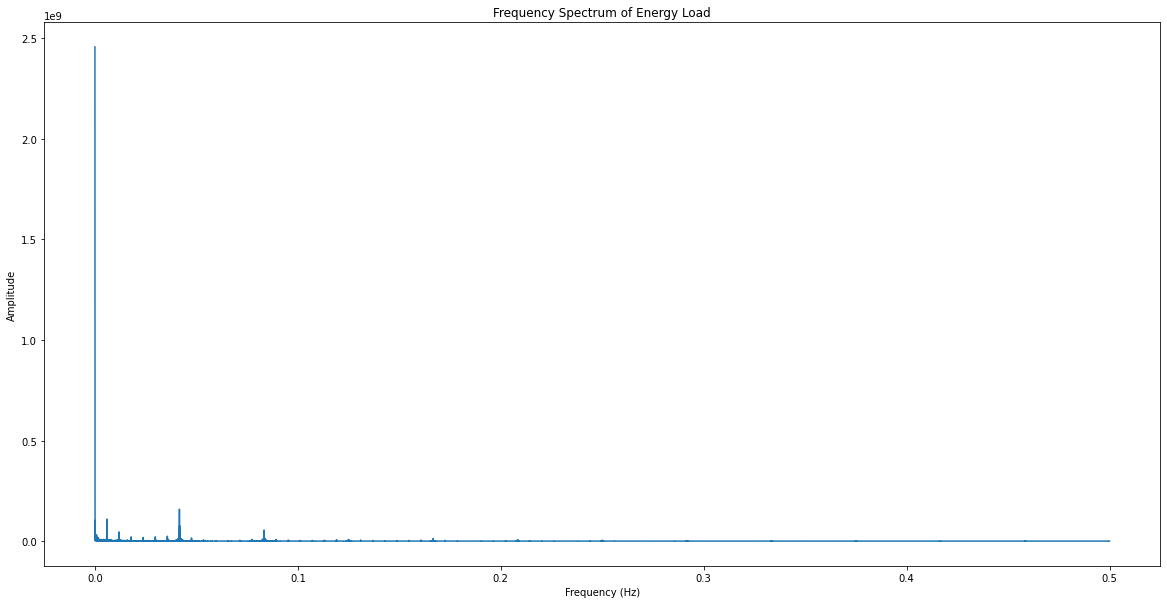

In [6]:
# Plot the amplitude spectrum
plt.figure(figsize=(20, 10))
plt.plot(freqs[:n // 2], np.abs(spectrum)[:n // 2])  # Only plot positive frequencies
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Energy Load')
plt.show()

The highest amplitude is for a period of "infinite hours", which means no oscillation / a static value. This was removed by a filter

The other peaks are for values of around:
- 24 hours => a day
- 168 hours => 7 days / a week
- 8760 hours => 365 days / a year
- 12 hours => day/night
- 3 years => maybe a bit random in a 6-year dataset
- 84 hours => 3.5 days / half a week


In [7]:
print(amplitudes)

[2.45755733e+09 3.74737263e+07 4.76763452e+07 ... 1.27454578e+07
 4.76763452e+07 3.74737263e+07]


For further analysis, we remove the peaks at around 0.0 Hertz and only keep values over 0.0002 Hertz.

c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


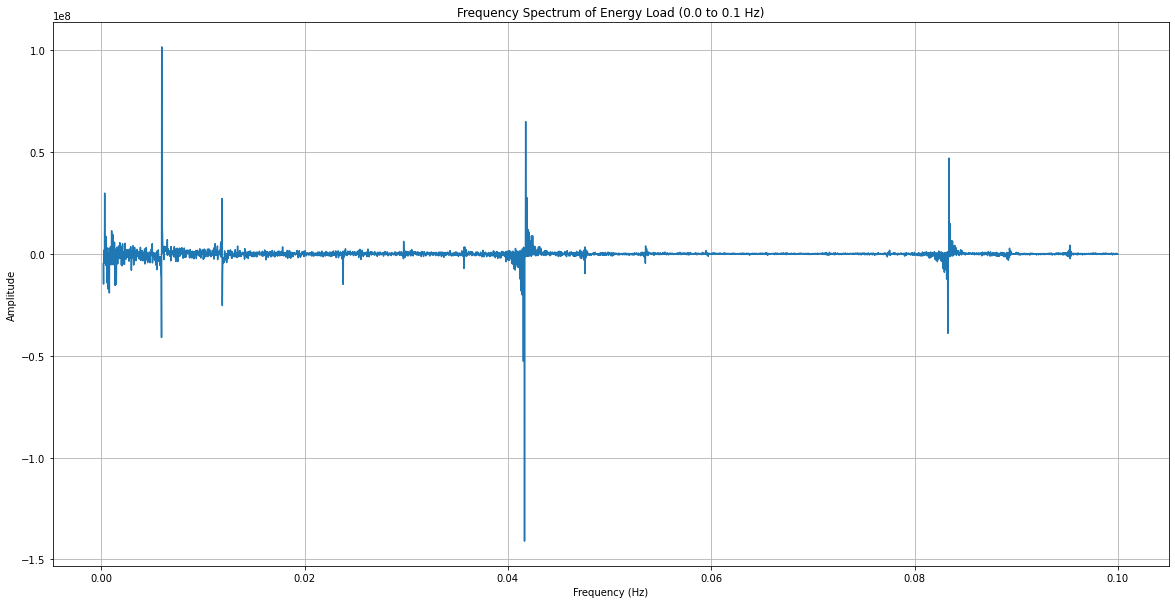

In [8]:
# Filter frequencies and spectrum for the range >0.0002 to 0.1 Hz
freq_range = (freqs > 0.0002) & (freqs <= 0.1)  # Frequency mask for the range from 0.0 to 0.1 Hz

# Apply the mask to both freqs and spectrum
filtered_freqs = freqs[freq_range]
filtered_spectrum = spectrum[freq_range]

# Plot the filtered frequency spectrum
plt.figure(figsize=(20, 10))
plt.plot(filtered_freqs, filtered_spectrum)  # Plot only the filtered frequencies
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Energy Load (0.0 to 0.1 Hz)')
plt.grid(True)
plt.show()

In [9]:
# Get the top 10 frequencies, their amplitudes, and phases
top_indices = np.argsort(filtered_spectrum)[-10:]  # Get the top 10 indices of the highest amplitudes
top_freqs = filtered_freqs[top_indices]
top_amplitudes = np.abs(filtered_spectrum[top_indices])  # Amplitude of the top frequencies
top_phases = np.angle(filtered_spectrum[top_indices])  # Phase of the top frequencies


# Print the 10 frequencies with the highest amplitudes and their corresponding periods
print("Top 10 frequencies with highest amplitudes (in Hz) and their periods (in hours):")
for freq, amp in zip(top_freqs, top_amplitudes):
    period = 1 / freq  # Calculate the period (in hours) for each frequency
    print(f"Frequency: {freq:.4f} Hz, Amplitude: {amp:.4f}, Period: {period:.2f} hours")

Top 10 frequencies with highest amplitudes (in Hz) and their periods (in hours):
Frequency: 0.0420 Hz, Amplitude: 15486916.4671, Period: 23.82 hours
Frequency: 0.0060 Hz, Amplitude: 16758675.6598, Period: 166.65 hours
Frequency: 0.0835 Hz, Amplitude: 16135277.5539, Period: 11.98 hours
Frequency: 0.0060 Hz, Amplitude: 26652552.9560, Period: 167.29 hours
Frequency: 0.0119 Hz, Amplitude: 45708119.8908, Period: 84.13 hours
Frequency: 0.0419 Hz, Amplitude: 31264744.8986, Period: 23.89 hours
Frequency: 0.0003 Hz, Amplitude: 29818615.4611, Period: 2922.00 hours
Frequency: 0.0834 Hz, Amplitude: 54650681.6576, Period: 11.99 hours
Frequency: 0.0418 Hz, Amplitude: 76448473.4629, Period: 23.95 hours
Frequency: 0.0060 Hz, Amplitude: 109455855.5552, Period: 167.93 hours


In [10]:
print(filtered_spectrum[:10])  # Print first few elements of the spectrum
print(np.iscomplexobj(filtered_spectrum))

[ -4947769.37208057-8927591.01676115j -14829012.9330672  -215246.46892286j
    351321.49071472-2061788.70250277j   1829154.49140233-6311518.08780101j
  -1368374.49922153-4100889.6936144j   -4525035.58206137+1881287.98678785j
  29783061.36155465+1455707.37194127j    747515.16924163-8435750.33582625j
  -1545883.31580568-3820524.66138966j   1298400.66685897+3803248.84484666j]
True


In [11]:
print(top_amplitudes)

[1.54869165e+07 1.67586757e+07 1.61352776e+07 2.66525530e+07
 4.57081199e+07 3.12647449e+07 2.98186155e+07 5.46506817e+07
 7.64484735e+07 1.09455856e+08]


In [12]:
#build sin waves to represent those frequencies:

df['sin_1'] = top_amplitudes[0] * np.sin(2 * np.pi * top_freqs[0] * np.arange(len(df)) + top_phases[0])
df['sin_2'] = top_amplitudes[1] * np.sin(2 * np.pi * top_freqs[1] * np.arange(len(df)) + top_phases[1])
df['sin_3'] = top_amplitudes[2] * np.sin(2 * np.pi * top_freqs[2] * np.arange(len(df)) + top_phases[2])
df['sin_4'] = top_amplitudes[3] * np.sin(2 * np.pi * top_freqs[3] * np.arange(len(df)) + top_phases[3])
df['sin_5'] = top_amplitudes[4] * np.sin(2 * np.pi * top_freqs[4] * np.arange(len(df)) + top_phases[4])
df['sin_6'] = top_amplitudes[5] * np.sin(2 * np.pi * top_freqs[5] * np.arange(len(df)) + top_phases[5])
df['sin_7'] = top_amplitudes[6] * np.sin(2 * np.pi * top_freqs[6] * np.arange(len(df)) + top_phases[6])
df['sin_8'] = top_amplitudes[7] * np.sin(2 * np.pi * top_freqs[7] * np.arange(len(df)) + top_phases[7])
df['sin_9'] = top_amplitudes[8] * np.sin(2 * np.pi * top_freqs[8] * np.arange(len(df)) + top_phases[8])
df['sin_10'] = top_amplitudes[9] * np.sin(2 * np.pi * top_freqs[9] * np.arange(len(df)) + top_phases[9])

In [13]:
#Sum up the sin waves

df['combined_sin'] = df[['sin_1', 'sin_2', 'sin_3', 'sin_4', 'sin_5', 'sin_6', 'sin_7', 'sin_8', 'sin_9', 'sin_10']].sum(axis=1)

In [14]:
df['sin_4']

time
2018-11-01 00:00:00   -1.220615e+07
2018-11-01 01:00:00   -1.130787e+07
2018-11-01 02:00:00   -1.039363e+07
2018-11-01 03:00:00   -9.464739e+06
2018-11-01 04:00:00   -8.522496e+06
                           ...     
2024-10-30 19:00:00    1.014330e+07
2024-10-30 20:00:00    9.210662e+06
2024-10-30 21:00:00    8.265029e+06
2024-10-30 22:00:00    7.307739e+06
2024-10-30 23:00:00    6.340141e+06
Name: sin_4, Length: 52620, dtype: float64

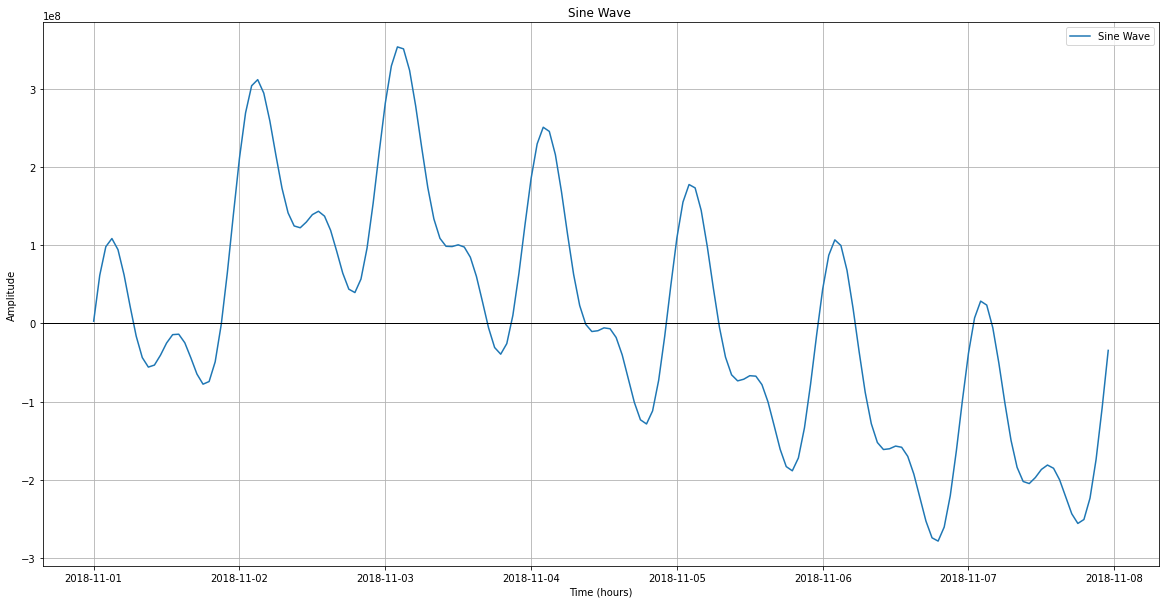

In [15]:
import numpy as np
import matplotlib.pyplot as plt


# Plot the sine wave
plt.figure(figsize=(20, 10))
plt.plot(df.index[0:168], df['combined_sin'][0:168], label="Sine Wave")
plt.title('Sine Wave ')
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.axhline(0, color='black',linewidth=1)
plt.legend()
plt.show()

In [16]:
# Extract dominant frequencies and their amplitudes
dominant_freqs = freqs[np.argsort(np.abs(spectrum))[:5]]  # Top 5 frequencies
dominant_amplitudes = np.abs(spectrum)[np.argsort(np.abs(spectrum))[:5]]  # Corresponding amplitudes

# Add these as new columns in the dataframe for modeling
df['freq_1'] = dominant_freqs[0]
df['amp_1'] = dominant_amplitudes[0]
df['freq_2'] = dominant_freqs[1]
df['amp_2'] = dominant_amplitudes[1]
df['freq_3'] = dominant_freqs[2]
df['amp_3'] = dominant_amplitudes[2]
df['freq_4'] = dominant_freqs[3]
df['amp_4'] = dominant_amplitudes[3]
df['freq_5'] = dominant_freqs[4]
df['amp_5'] = dominant_amplitudes[4]



print(df.head())

                         load  price  biomass    water  offshore   onshore  \
time                                                                         
2018-11-01 00:00:00  48879.50  40.86  4754.75  1583.00   2721.00  11628.50   
2018-11-01 01:00:00  47312.50  41.10  4741.25  1587.50   2678.00  11029.00   
2018-11-01 02:00:00  46093.75  40.59  4733.25  1567.50   2836.75  11025.00   
2018-11-01 03:00:00  46710.50  40.09  4725.25  1550.00   2968.50  10480.25   
2018-11-01 04:00:00  47624.25  39.11  4715.00  1535.75   2765.25  10871.25   

                     solar  other_renewable  nuclear   lignite  ...    freq_1  \
time                                                            ...             
2018-11-01 00:00:00    0.0           153.00   7933.0  16108.75  ... -0.263495   
2018-11-01 01:00:00    0.0           153.00   7933.5  16119.00  ... -0.263495   
2018-11-01 02:00:00    0.0           153.00   7927.0  16111.00  ... -0.263495   
2018-11-01 03:00:00    0.0           152.50   79

### Convert dominant frequencies and amplitudes to sin waves and add them to the dataset

In [17]:
df['sin_wave_1'] = dominant_amplitudes[0] * np.sin(2 * np.pi * dominant_freqs[0] * df['hour'])
df['sin_wave_2'] = dominant_amplitudes[1] * np.sin(2 * np.pi * dominant_freqs[1] * df['hour'])
df['sin_wave_3'] = dominant_amplitudes[2] * np.sin(2 * np.pi * dominant_freqs[2] * df['hour'])
df['sin_wave_4'] = dominant_amplitudes[3] * np.sin(2 * np.pi * dominant_freqs[3] * df['hour'])
df['sin_wave_5'] = dominant_amplitudes[4] * np.sin(2 * np.pi * dominant_freqs[4] * df['hour'])


In [18]:
df['sin_wave_5']

time
2018-11-01 00:00:00      0.000000
2018-11-01 01:00:00    546.599491
2018-11-01 02:00:00     71.019719
2018-11-01 03:00:00   -537.371893
2018-11-01 04:00:00   -140.840495
                          ...    
2024-10-30 19:00:00   -180.390984
2024-10-30 20:00:00   -527.827076
2024-10-30 21:00:00    111.810367
2024-10-30 22:00:00    542.354606
2024-10-30 23:00:00    -41.342187
Name: sin_wave_5, Length: 52620, dtype: float64

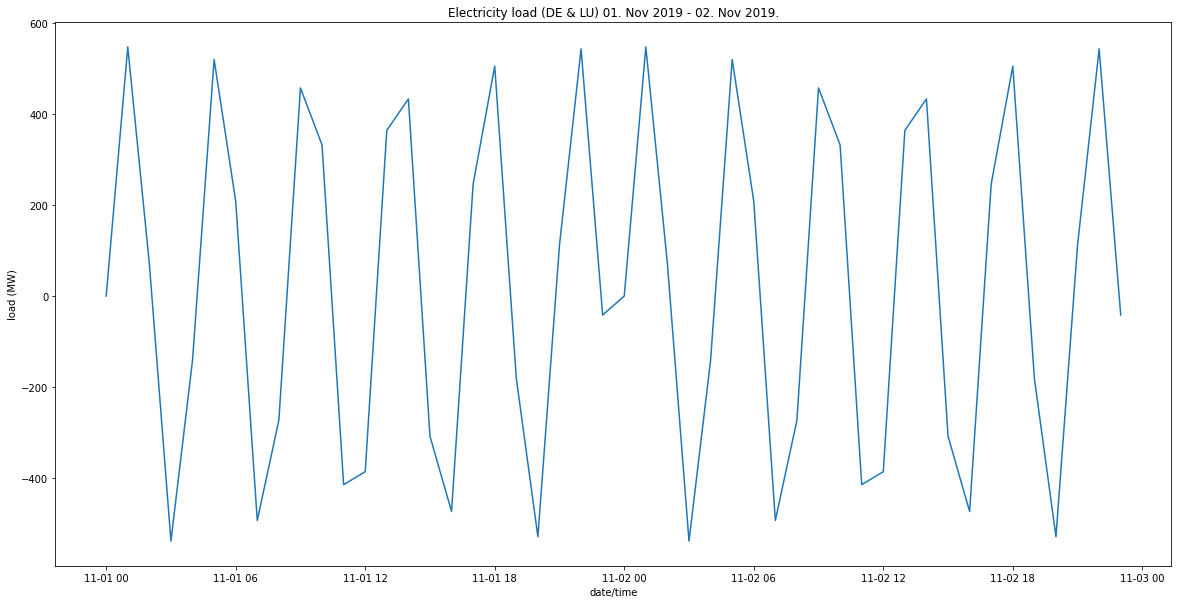

In [19]:
df_days = df.iloc[:48]

plt.figure(figsize=(20, 10))
plt.plot(df_days.index, df_days['sin_wave_5'])
0.0416
plt.title('Electricity load (DE & LU) 01. Nov 2019 - 02. Nov 2019.')
plt.xlabel('date/time')
plt.ylabel('load (MW)')
plt.show()

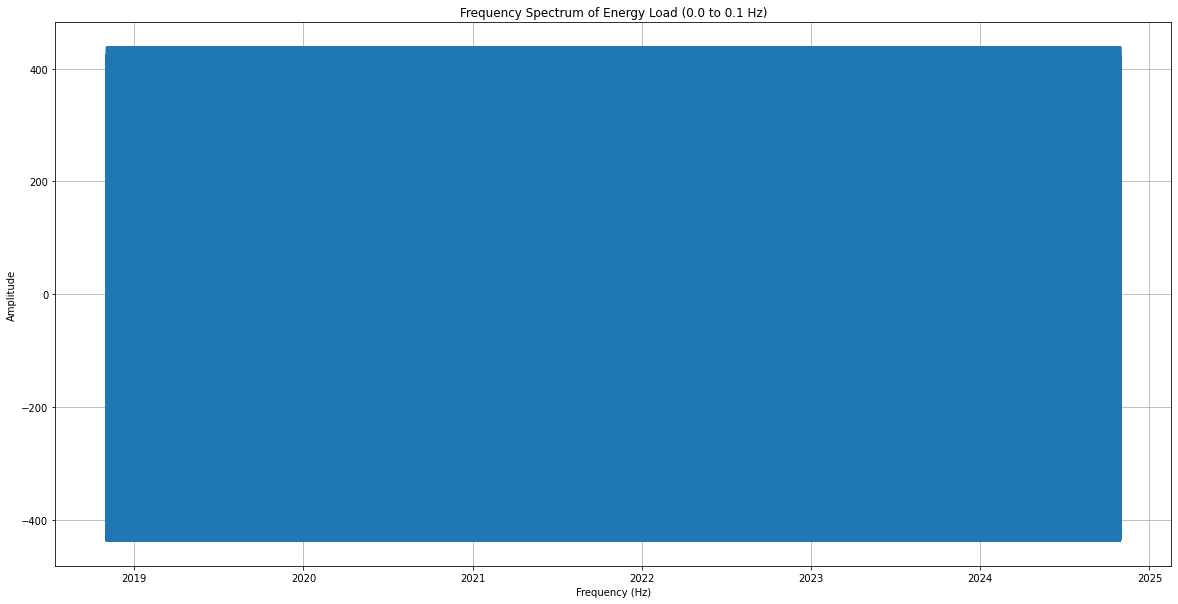

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(df.index, df['sin_wave_1'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Energy Load (0.0 to 0.1 Hz)')
plt.grid(True)
plt.show()

### Power Spectral Density (PSD)

You can calculate the Power Spectral Density (PSD) to understand the distribution of power into frequency components. This can help identify how different frequencies (e.g., daily, weekly) contribute to the energy load.

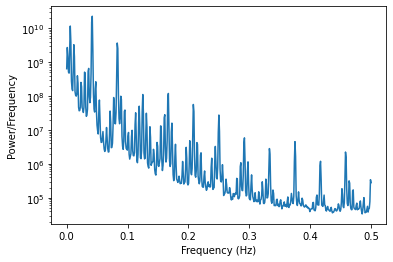

In [21]:
from scipy.signal import welch

f, Pxx = welch(energy_load, fs=1, nperseg=1024)  # Adjust fs as per your data's time interval

plt.semilogy(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency')
plt.show()

### Seasonal Decomposition: 

Use Seasonal Decomposition of Time Series (e.g., STL decomposition) to separate the trend, seasonal, and residual components of the energy load time series, helping in isolating periodic fluctuations.

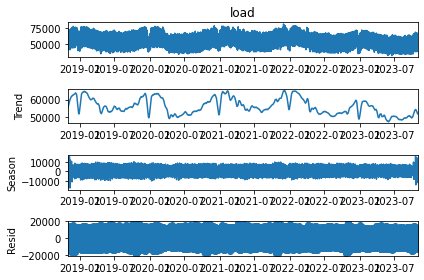

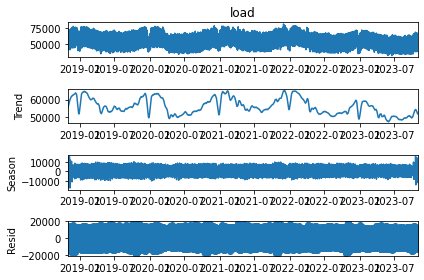

In [22]:
from statsmodels.tsa.seasonal import STL

stl = STL(energy_load, period=260) #5 years, 260 weeks
result = stl.fit()
result.plot()

## Train / Test split

Repeat train test splitting after adding sin waves to the complete dataset.

In [23]:
# Check for the range of the data to verify the time span
print(df.index.min(), df.index.max())  # Should show range from Nov 1st, 2018 to Oct 31st, 2024

# Split the data into training and test sets (5:1 years)
train_size = int(0.83296 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Check the size of the splits
print(f"Training data from {train.index.min()} to {train.index.max()}")
print(f"Testing data from {test.index.min()} to {test.index.max()}")


2018-11-01 00:00:00 2024-10-30 23:00:00
Training data from 2018-11-01 00:00:00 to 2023-10-30 23:00:00
Testing data from 2023-10-31 00:00:00 to 2024-10-30 23:00:00


## Prediction

### ARIMAX without spectral data

The data has several obvious seasonalities (yearly, weekly, daily). The information about those "seasons" is already included in the dataset as columns 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'dayofyear_sin' and 'dayofyear_cos'. They can be given to the ARIMA model as exogenous regressors. Therefore, it is not necessary to use a SARIMA model and train it for a certain seasonality.

In [24]:
%%time

from statsmodels.tsa.arima.model import ARIMA

# Define the features (including spectral and external variables)
exog_features = df[['price', 'biomass', 'water', 'offshore', 'onshore', 'solar', 'other_renewable',
                     'nuclear', 'lignite', 'coal', 'gas', 'pumped', 'other_conv', 
                     'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 
                     'month_cos', 'dayofyear_sin', 'dayofyear_cos']]


X_train, y_train = train[exog_features.columns], train['load']
X_test, y_test = test[exog_features.columns], test['load']

# Train an ARIMAX model (adjust p, d, q for ARIMA order)
model = ARIMA(y_train, exog=X_train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast on the test data
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)

c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed 

Wall time: 1min 49s


### Evaluation

In [25]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, forecast)
print(f'MAPE: {mape:.4f}')

MAPE: 0.5441


### Plot

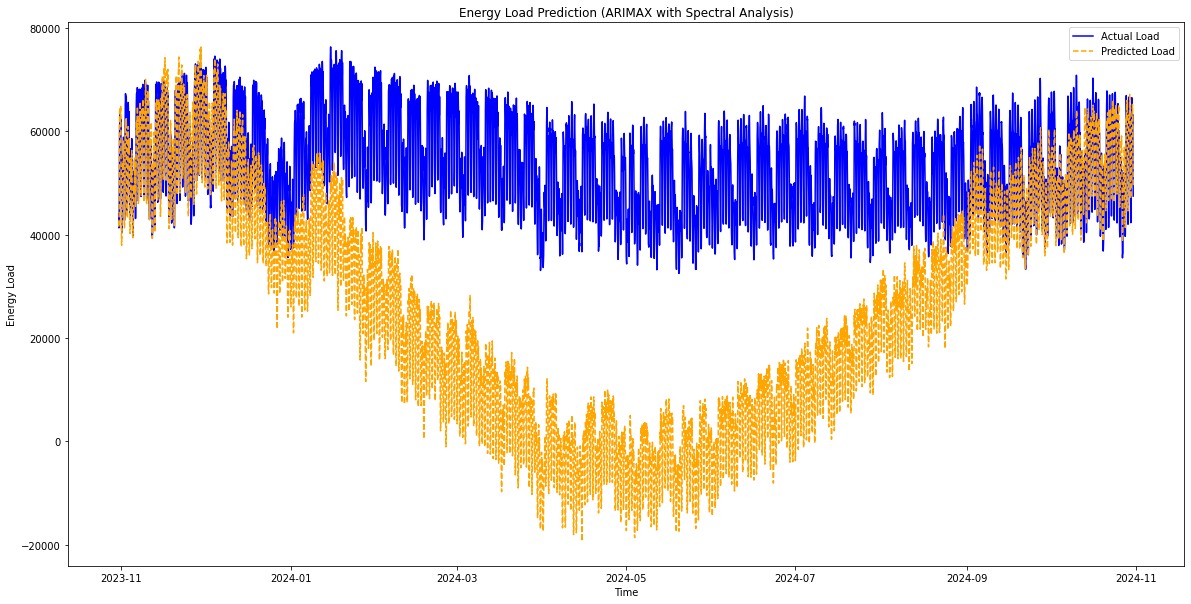

In [26]:
# Plot actual vs predicted energy load
plt.figure(figsize=(20, 10))
plt.plot(test.index, y_test, color='blue', label='Actual Load')
plt.plot(test.index, forecast, color='orange', label='Predicted Load', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

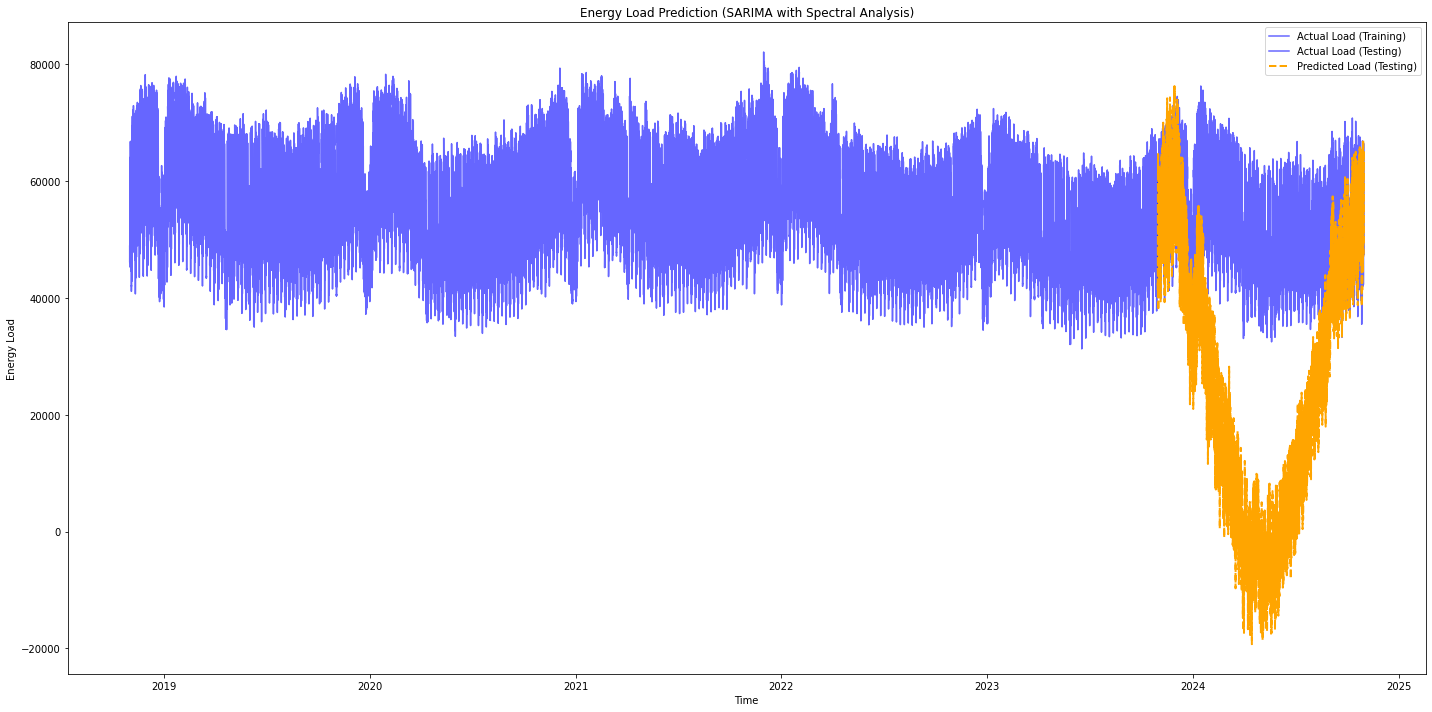

In [27]:
# Plot actual vs predicted energy load for the whole dataset (train + test) and predictions
plt.figure(figsize=(20, 10))

# Plot the actual load for the training and testing set
plt.plot(df.index[:train_size], y_train, label='Actual Load (Training)', color='blue', alpha=0.6)
plt.plot(df.index[train_size:], y_test, label='Actual Load (Testing)', color='blue', alpha=0.6)

# Plot the predicted load (only for the test period)
plt.plot(test.index, forecast, label='Predicted Load (Testing)', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (SARIMA with Spectral Analysis)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The results of this configuration are really off, especially when looking at the whole dataset in the second figure.

## ARIMAX with spectral data

The next experiment will include the spectral data in the exogenous regressors, instead of the previous exogenous regressors.

In [28]:
%%time

from statsmodels.tsa.arima.model import ARIMA

# Define the features (including spectral variables)
exog_features = df[['sin_wave_1', 'sin_wave_2', 'sin_wave_3', 'sin_wave_4', 'sin_wave_5']]


X_train, y_train = train[exog_features.columns], train['load']
X_test, y_test = test[exog_features.columns], test['load']

# Train an ARIMAX model (adjust p, d, q for ARIMA order)
model = ARIMA(y_train, exog=X_train, order=(2, 0, 2))
model_fit = model.fit()

# Forecast on the test data
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)


c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed 

Wall time: 21.6 s


c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


### Evaluation

In [29]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, forecast)
print(f'MAPE: {mape:.4f}')

MAPE: 0.1679


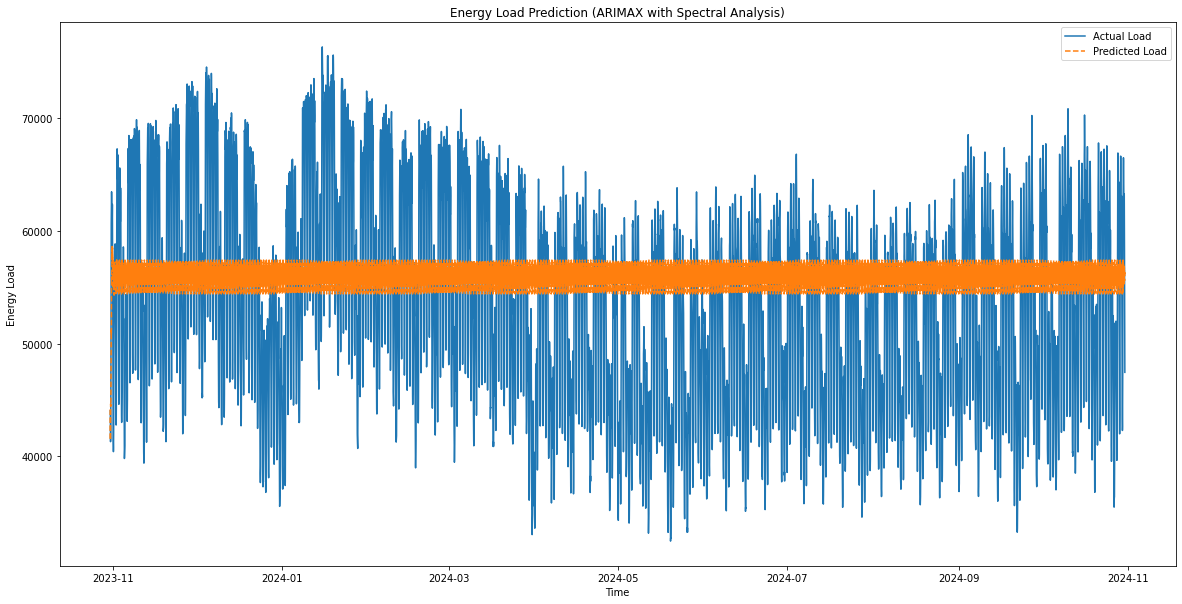

In [30]:
# Plot actual vs predicted energy load
plt.figure(figsize=(20, 10))
plt.plot(test.index, y_test, label='Actual Load')
plt.plot(test.index, forecast, label='Predicted Load', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

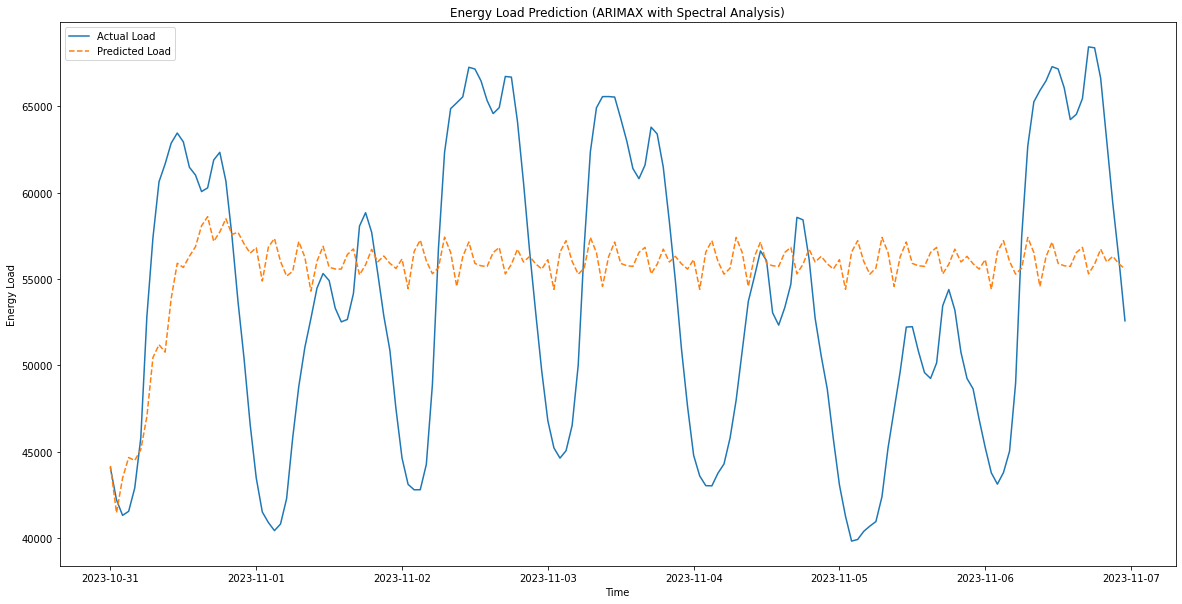

In [31]:
#Plot only one week


start = 0
end = 168

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


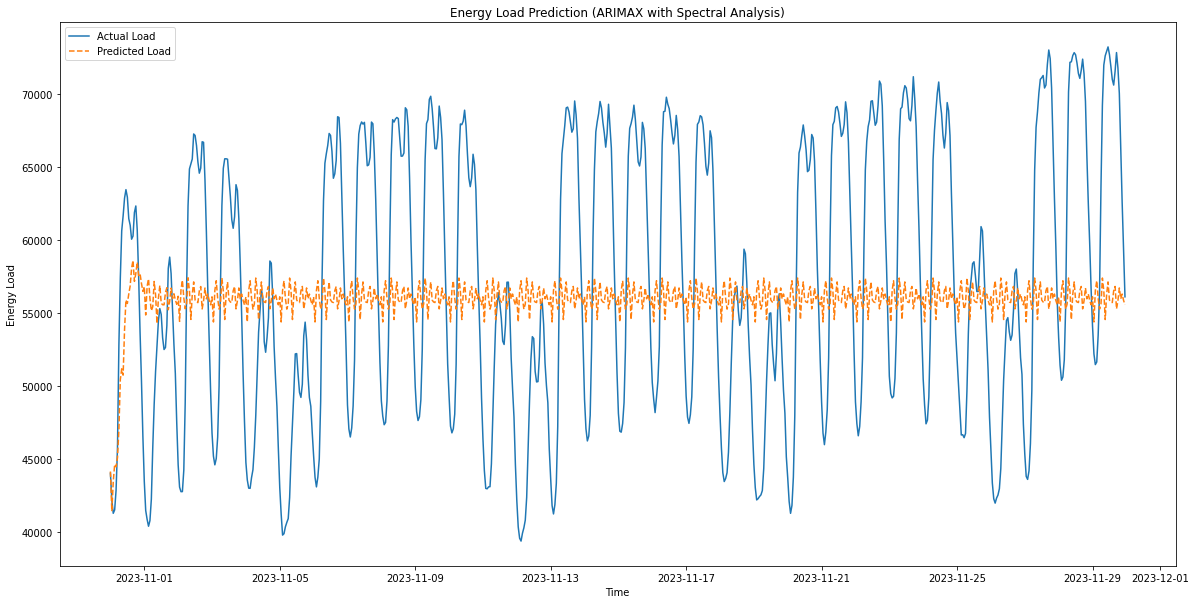

In [32]:
#Plot only one month
start = 0
end = 720

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

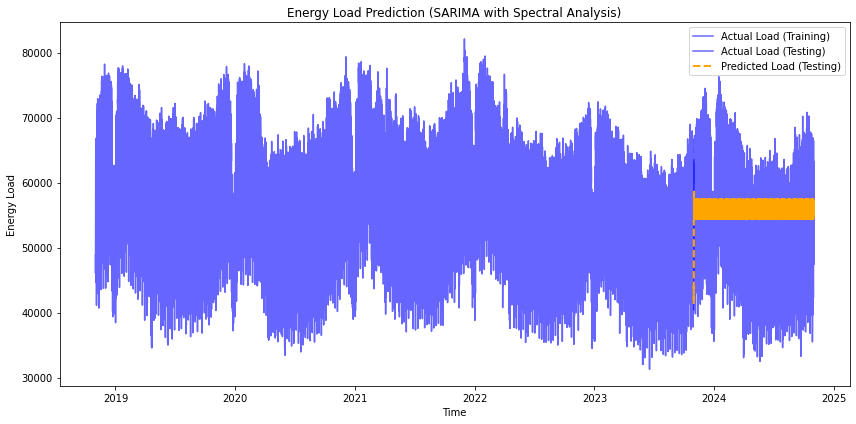

In [33]:
# Plot actual vs predicted energy load for the whole dataset (train + test) and predictions
plt.figure(figsize=(12, 6))

# Plot the actual load for the training and testing set
plt.plot(df.index[:train_size], y_train, label='Actual Load (Training)', color='blue', alpha=0.6)
plt.plot(df.index[train_size:], y_test, label='Actual Load (Testing)', color='blue', alpha=0.6)

# Plot the predicted load (only for the test period)
plt.plot(test.index, forecast, label='Predicted Load (Testing)', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (SARIMA with Spectral Analysis)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## ARIMAX with sin_x

In [35]:
%%time

from statsmodels.tsa.arima.model import ARIMA

# Define the features (including spectral variables)
exog_features = df[['sin_1', 'sin_2', 'sin_3', 'sin_4', 'sin_5', 'sin_6', 'sin_7', 'sin_8', 'sin_9', 'sin_10']]


X_train, y_train = train[exog_features.columns], train['load']
X_test, y_test = test[exog_features.columns], test['load']

# Train an ARIMAX model (adjust p, d, q for ARIMA order)
model = ARIMA(y_train, exog=X_train, order=(2, 0, 2))
model_fit = model.fit()

# Forecast on the test data
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)

c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Wall time: 17.7 s


c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [36]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, forecast)
print(f'MAPE: {mape:.4f}')

MAPE: 0.1689


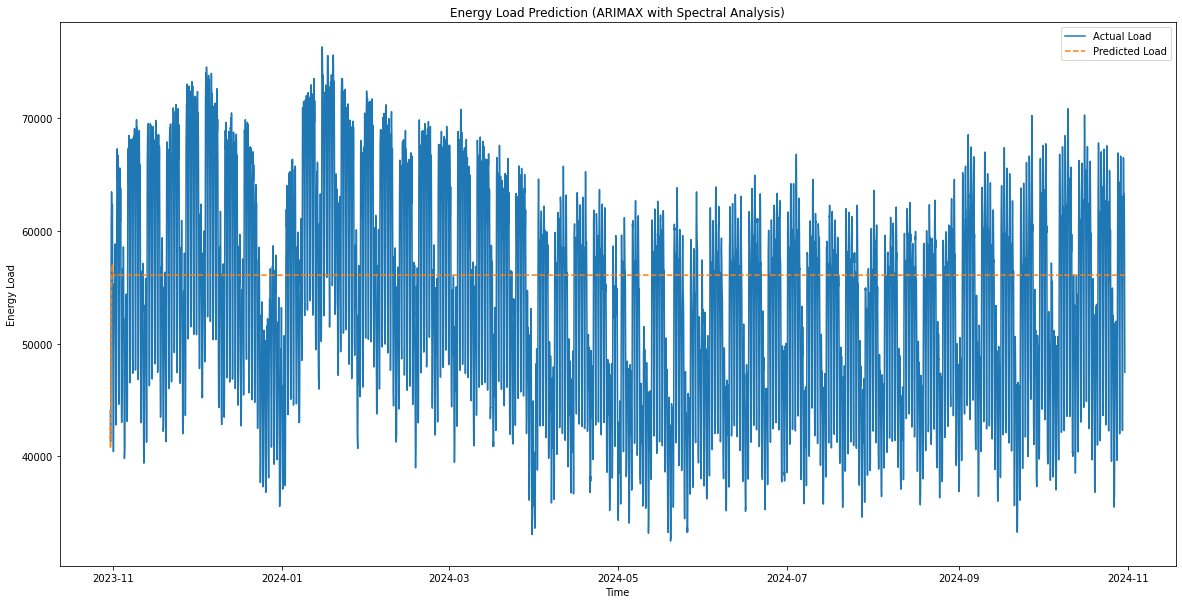

In [37]:
# Plot actual vs predicted energy load
plt.figure(figsize=(20, 10))
plt.plot(test.index, y_test, label='Actual Load')
plt.plot(test.index, forecast, label='Predicted Load', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

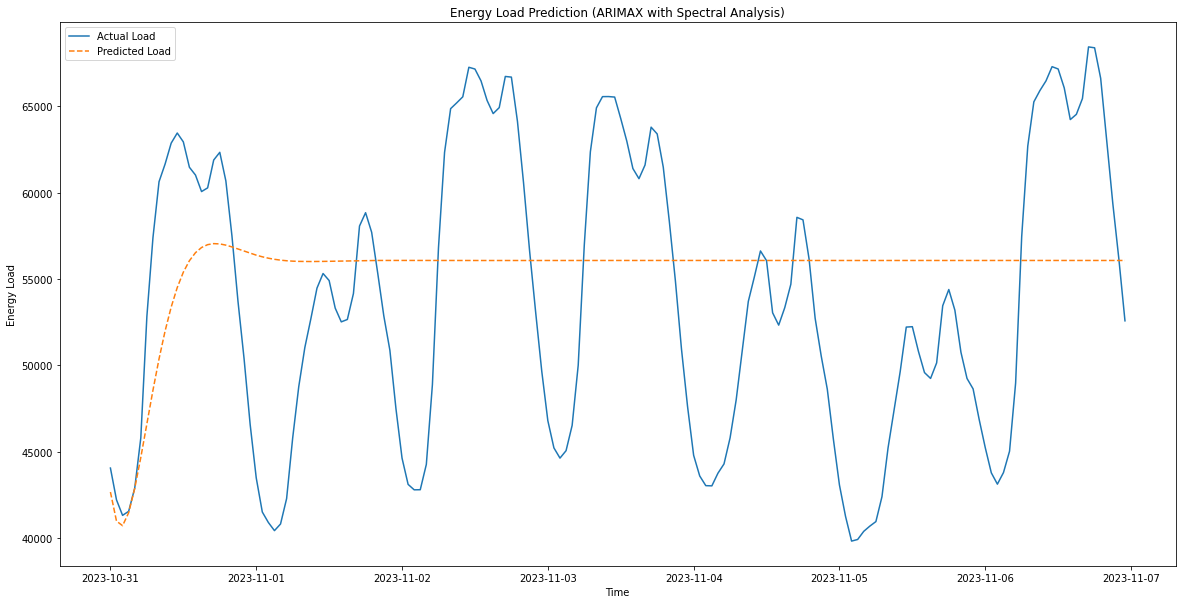

In [38]:
#Plot only one week


start = 0
end = 168

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


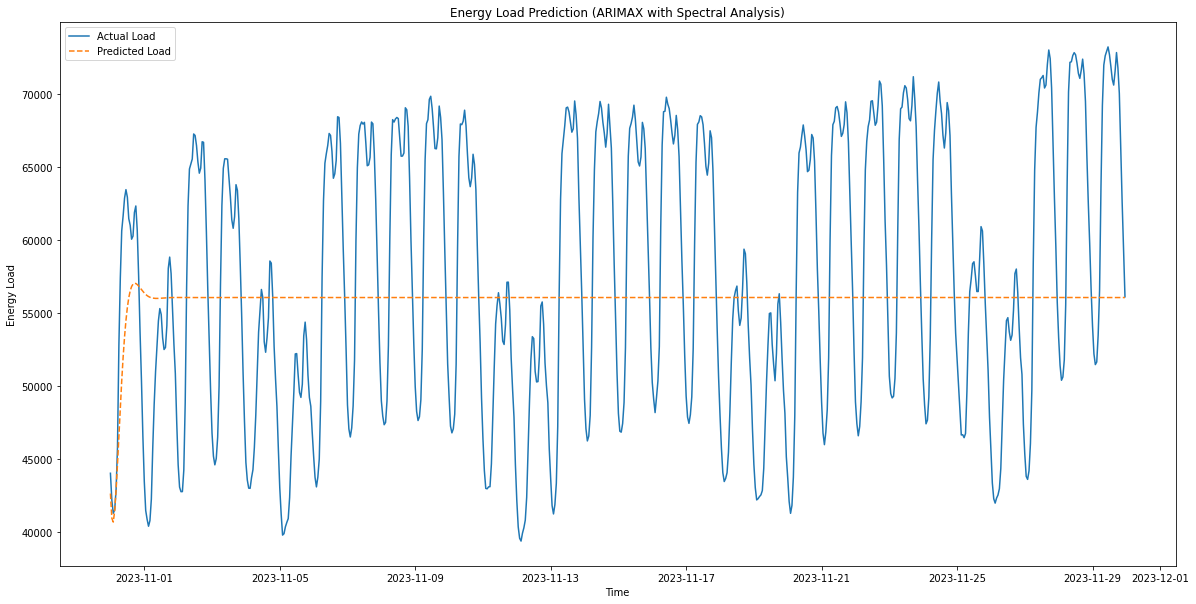

In [39]:
#Plot only one month
start = 0
end = 720

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

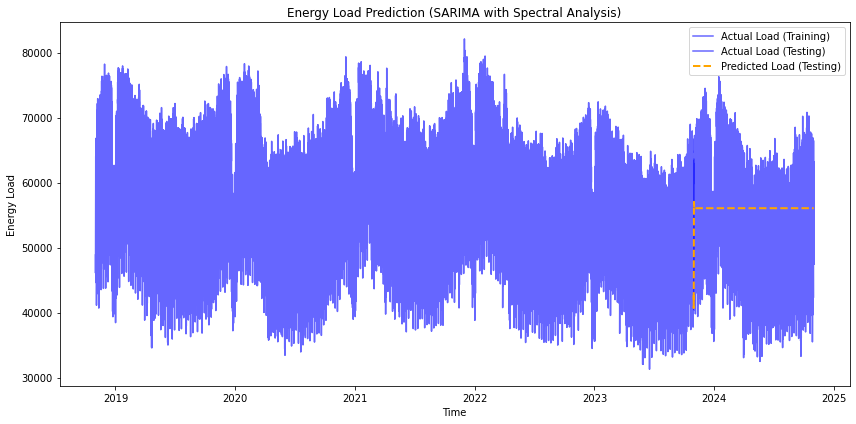

In [40]:
# Plot actual vs predicted energy load for the whole dataset (train + test) and predictions
plt.figure(figsize=(12, 6))

# Plot the actual load for the training and testing set
plt.plot(df.index[:train_size], y_train, label='Actual Load (Training)', color='blue', alpha=0.6)
plt.plot(df.index[train_size:], y_test, label='Actual Load (Testing)', color='blue', alpha=0.6)

# Plot the predicted load (only for the test period)
plt.plot(test.index, forecast, label='Predicted Load (Testing)', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (SARIMA with Spectral Analysis)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Manually find out, which of the 10 sin_x are important

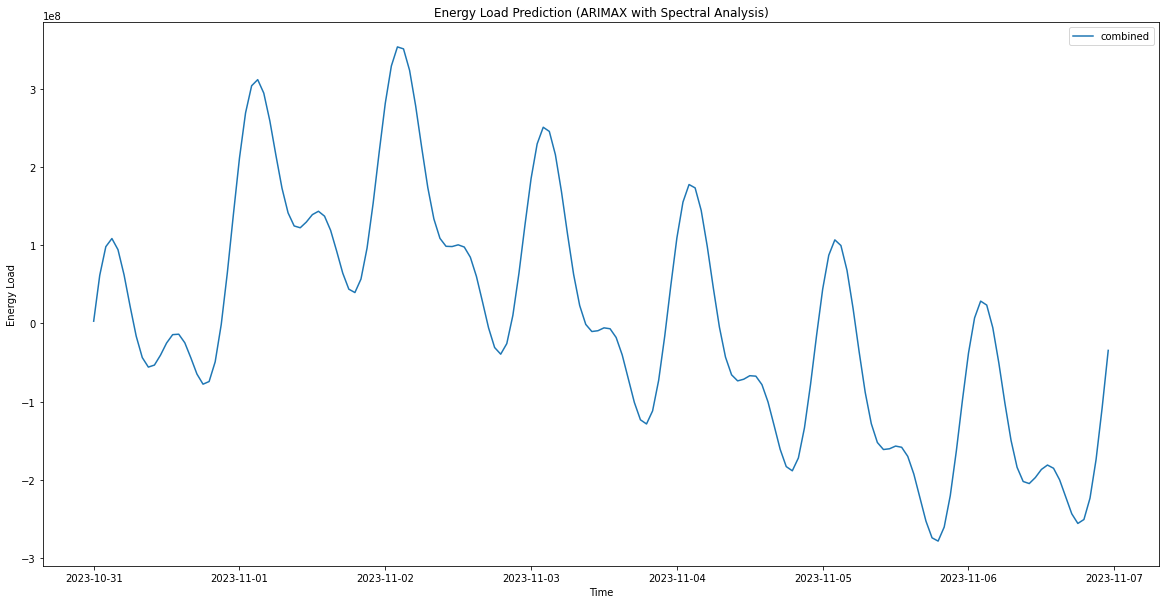

In [41]:
#Plot only one week


start = 0
end = 168

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = test['load'][start:end]
sin1 = test['sin_1'][start:end]
sin2 = test['sin_2'][start:end]
sin3 = test['sin_3'][start:end]
sin4 = test['sin_4'][start:end]
sin5 = test['sin_5'][start:end]
sin6 = test['sin_6'][start:end]
sin7 = test['sin_7'][start:end]
sin8 = test['sin_8'][start:end]
sin9 = test['sin_9'][start:end]
sin10 = test['sin_10'][start:end]
comb = test['combined_sin'][start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
#plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, comb, label='combined')
#plt.plot(section, sin1, label='sin 1')
#plt.plot(section, sin2, label='sin 2')
#plt.plot(section, sin3, label='sin 3')
#plt.plot(section, sin4, label='sin 4')
#plt.plot(section, sin5, label='sin 5')
#plt.plot(section, sin6, label='sin 6')
#plt.plot(section, sin7, label='sin 7')
#plt.plot(section, sin8, label='sin 8')
#plt.plot(section, sin9, label='sin 9')
#plt.plot(section, sin10, label='sin 10')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


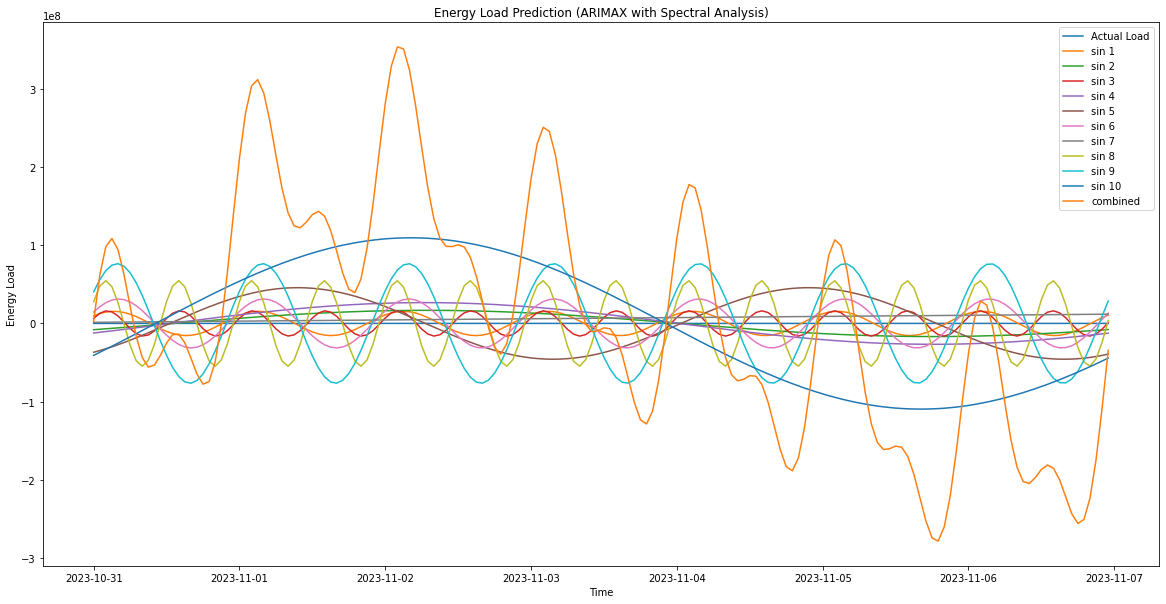

In [42]:

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, sin1, label='sin 1')
plt.plot(section, sin2, label='sin 2')
plt.plot(section, sin3, label='sin 3')
plt.plot(section, sin4, label='sin 4')
plt.plot(section, sin5, label='sin 5')
plt.plot(section, sin6, label='sin 6')
plt.plot(section, sin7, label='sin 7')
plt.plot(section, sin8, label='sin 8')
plt.plot(section, sin9, label='sin 9')
plt.plot(section, sin10, label='sin 10')
plt.plot(section, comb, label='combined')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


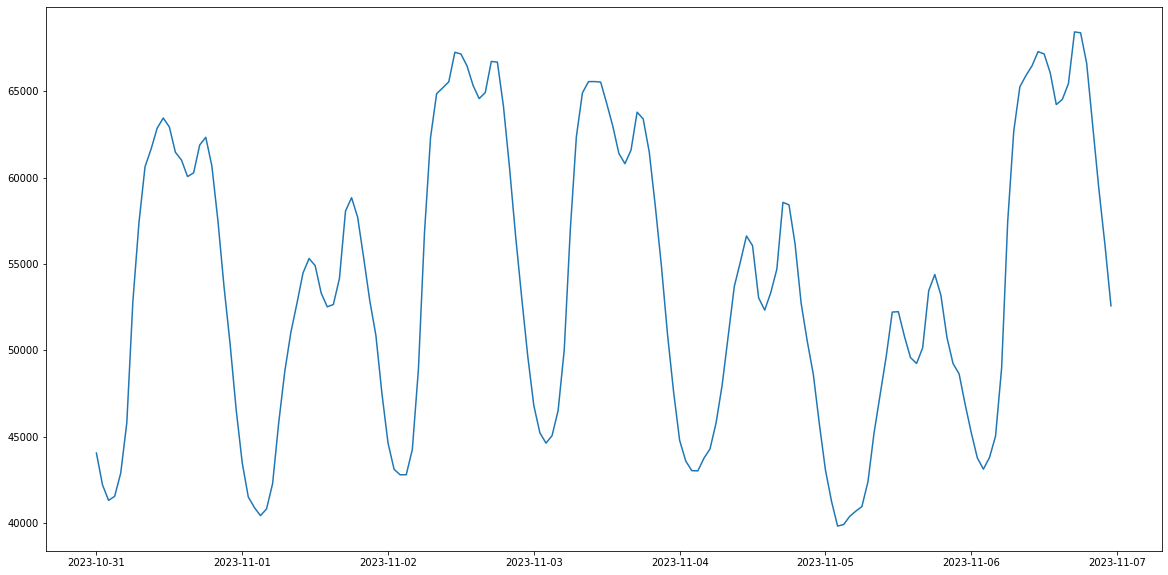

In [43]:
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.show()

## Using only limited number of sin waves

Keep only a few sin waves, representing:
 
 sin_1: 24 hours
 
 sin_5: 3.5 days
 
 sin_8: 12 hours
 
 sin_9: 24 hours
 
 sin_10: 1 week
 
The occurrence of two sin waves for 24 hours help recreating the two peaks before and after noon

In [59]:
%%time

from statsmodels.tsa.arima.model import ARIMA


exog_features = df[['combined_sin', 'sin_1', 'sin_5', 'sin_8', 'sin_9', 'sin_10']]


X_train, y_train = train[exog_features.columns], train['load']
X_test, y_test = test[exog_features.columns], test['load']

# Train an ARIMAX model (adjust p, d, q for ARIMA order)
model = ARIMA(y_train, exog=X_train, order=(2, 0, 2))
model_fit = model.fit()

# Forecast on the test data
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)

c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Wall time: 12.8 s


c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [60]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, forecast)
print(f'MAPE: {mape:.4f}')

MAPE: 0.1689


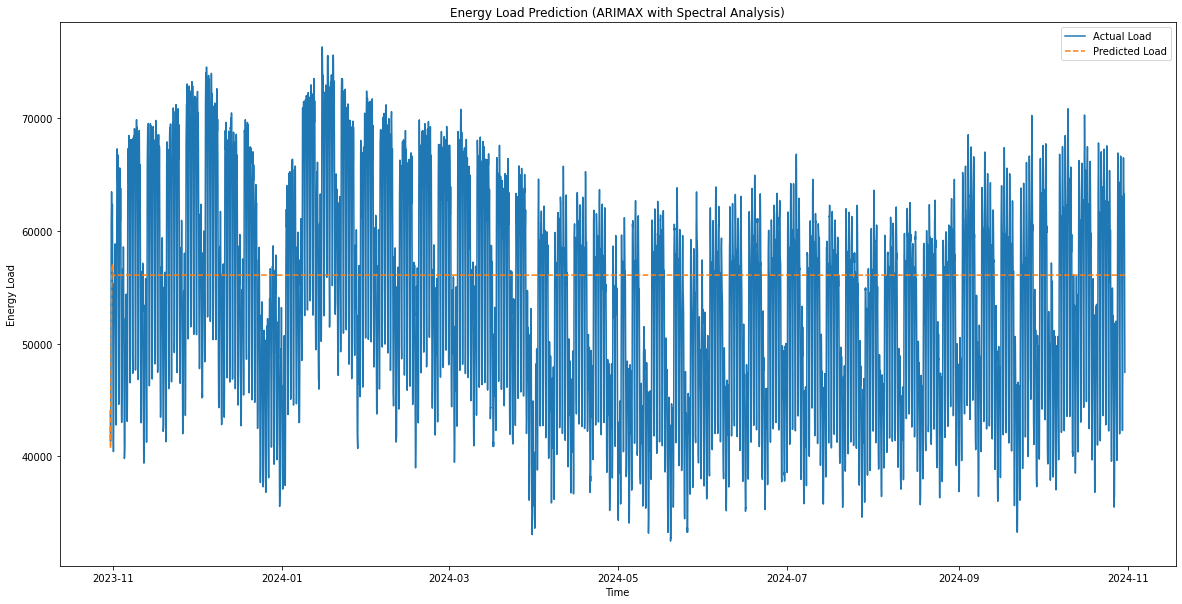

In [61]:
# Plot actual vs predicted energy load
plt.figure(figsize=(20, 10))
plt.plot(test.index, y_test, label='Actual Load')
plt.plot(test.index, forecast, label='Predicted Load', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

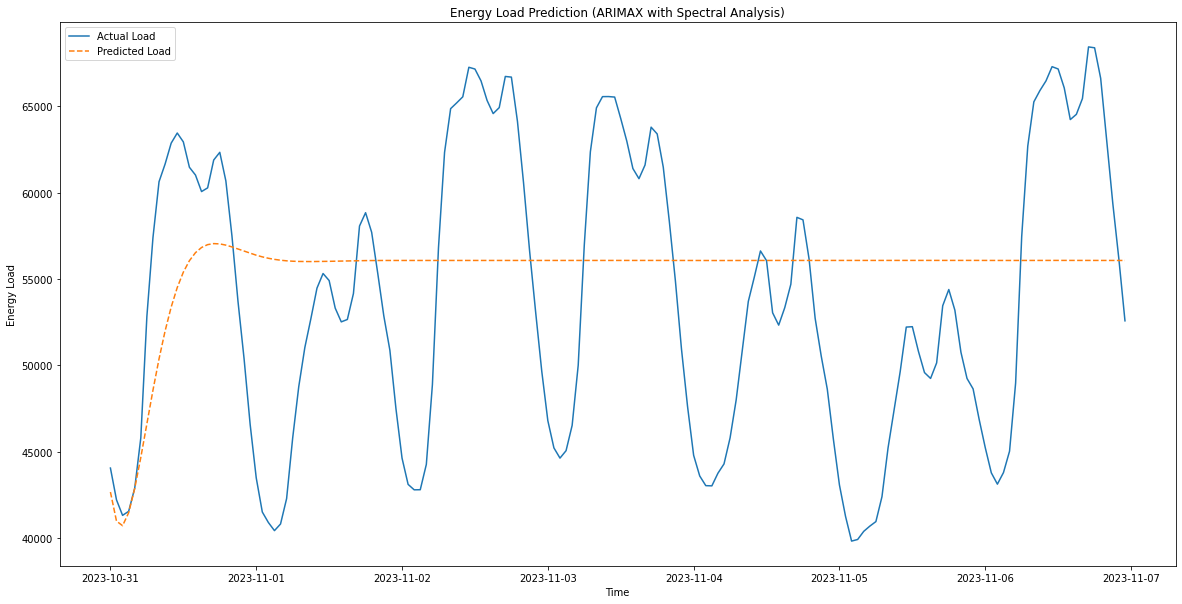

In [62]:
#Plot only one week


start = 0
end = 168

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


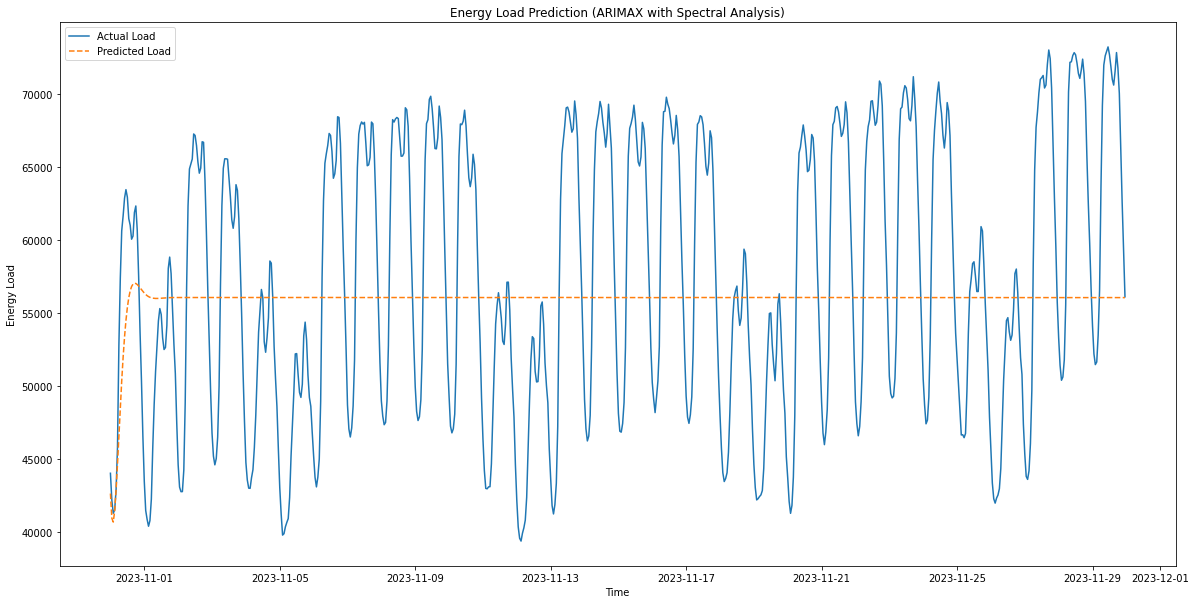

In [63]:
#Plot only one month
start = 0
end = 720

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

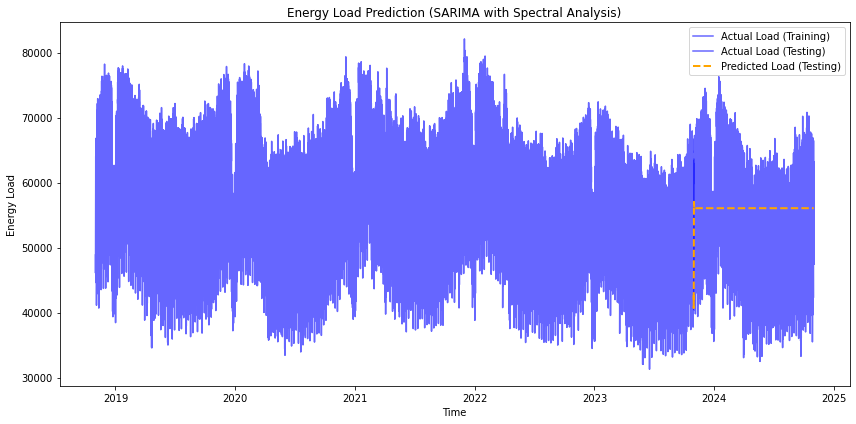

In [64]:
# Plot actual vs predicted energy load for the whole dataset (train + test) and predictions
plt.figure(figsize=(12, 6))

# Plot the actual load for the training and testing set
plt.plot(df.index[:train_size], y_train, label='Actual Load (Training)', color='blue', alpha=0.6)
plt.plot(df.index[train_size:], y_test, label='Actual Load (Testing)', color='blue', alpha=0.6)

# Plot the predicted load (only for the test period)
plt.plot(test.index, forecast, label='Predicted Load (Testing)', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (SARIMA with Spectral Analysis)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## sine waves without phase: sine_x

In [49]:
#build sin waves to represent those frequencies:

df['sine_1'] = top_amplitudes[0] * np.sin(2 * np.pi * top_freqs[0] * np.arange(len(df)))
df['sine_2'] = top_amplitudes[1] * np.sin(2 * np.pi * top_freqs[1] * np.arange(len(df)))
df['sine_3'] = top_amplitudes[2] * np.sin(2 * np.pi * top_freqs[2] * np.arange(len(df)))
df['sine_4'] = top_amplitudes[3] * np.sin(2 * np.pi * top_freqs[3] * np.arange(len(df)))
df['sine_5'] = top_amplitudes[4] * np.sin(2 * np.pi * top_freqs[4] * np.arange(len(df)))
df['sine_6'] = top_amplitudes[5] * np.sin(2 * np.pi * top_freqs[5] * np.arange(len(df)))
df['sine_7'] = top_amplitudes[6] * np.sin(2 * np.pi * top_freqs[6] * np.arange(len(df)))
df['sine_8'] = top_amplitudes[7] * np.sin(2 * np.pi * top_freqs[7] * np.arange(len(df)))
df['sine_9'] = top_amplitudes[8] * np.sin(2 * np.pi * top_freqs[8] * np.arange(len(df)))
df['sine_10'] = top_amplitudes[9] * np.sin(2 * np.pi * top_freqs[9] * np.arange(len(df)))

### Another train / test split after adding the new columns

In [51]:
# Check for the range of the data to verify the time span
print(df.index.min(), df.index.max())  # Should show range from Nov 1st, 2018 to Oct 31st, 2024

# Split the data into training and test sets (5:1 years)
train_size = int(0.83296 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Check the size of the splits
print(f"Training data from {train.index.min()} to {train.index.max()}")
print(f"Testing data from {test.index.min()} to {test.index.max()}")


2018-11-01 00:00:00 2024-10-30 23:00:00
Training data from 2018-11-01 00:00:00 to 2023-10-30 23:00:00
Testing data from 2023-10-31 00:00:00 to 2024-10-30 23:00:00


In [52]:
%%time

from statsmodels.tsa.arima.model import ARIMA

# Define the features (including spectral variables)
exog_features = df[['sine_1', 'sine_2', 'sine_3', 'sine_4', 'sine_5', 'sine_6', 'sine_7', 'sine_8', 'sine_9', 'sine_10']]


X_train, y_train = train[exog_features.columns], train['load']
X_test, y_test = test[exog_features.columns], test['load']

# Train an ARIMAX model (adjust p, d, q for ARIMA order)
model = ARIMA(y_train, exog=X_train, order=(2, 0, 2))
model_fit = model.fit()

# Forecast on the test data
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)

c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Wall time: 23.9 s


c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [53]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, forecast)
print(f'MAPE: {mape:.4f}')

MAPE: 0.1577


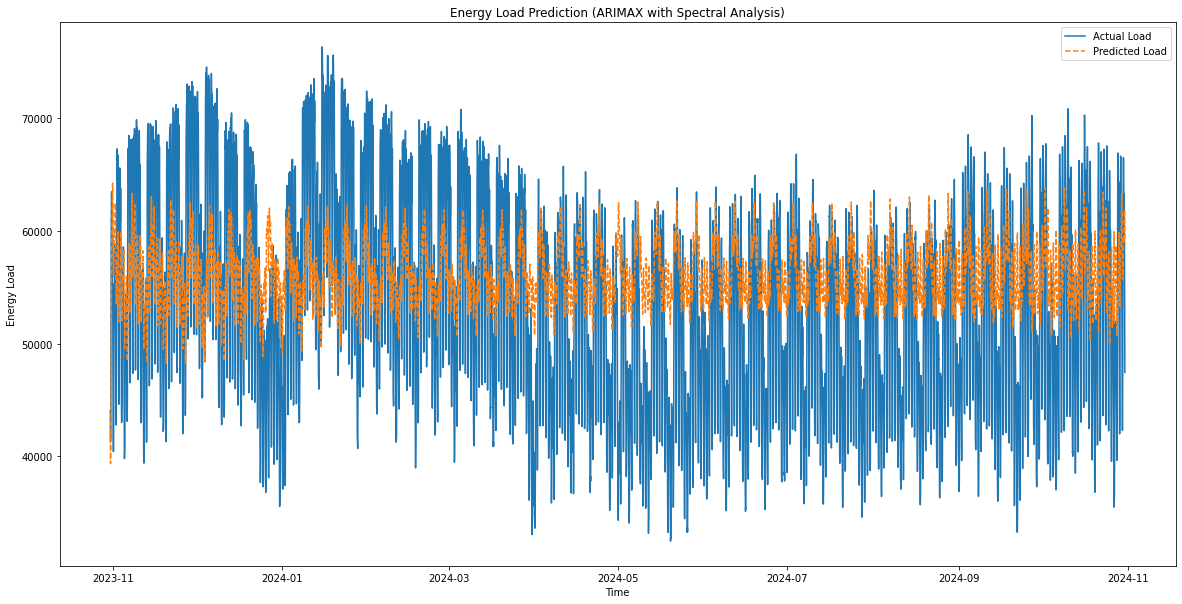

In [54]:
# Plot actual vs predicted energy load
plt.figure(figsize=(20, 10))
plt.plot(test.index, y_test, label='Actual Load')
plt.plot(test.index, forecast, label='Predicted Load', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

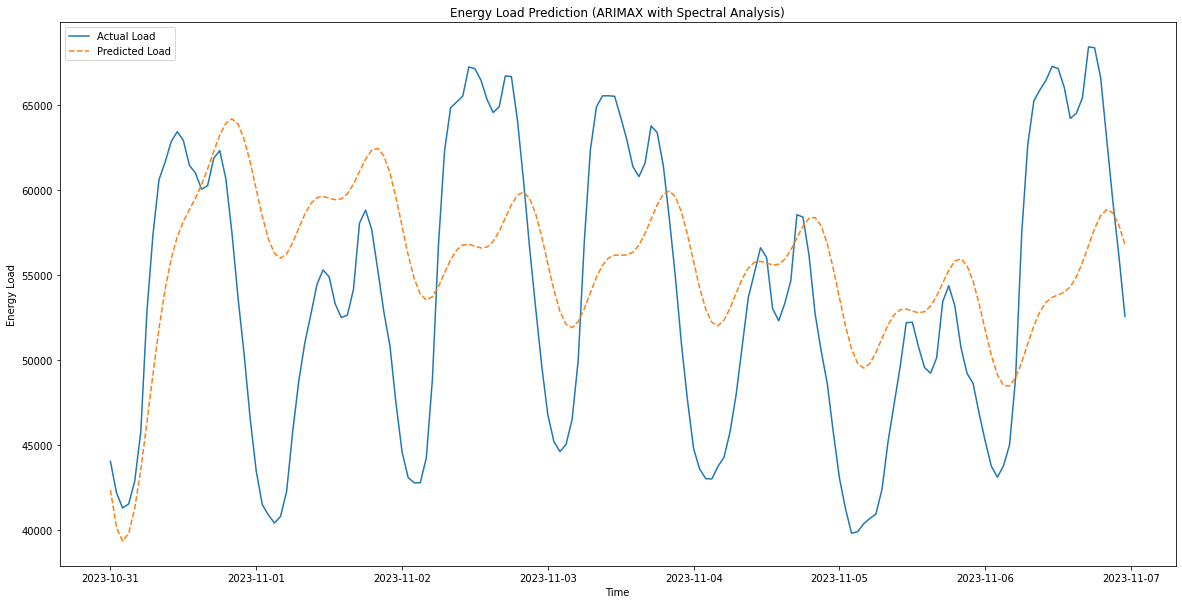

In [55]:
#Plot only one week


start = 0
end = 168

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


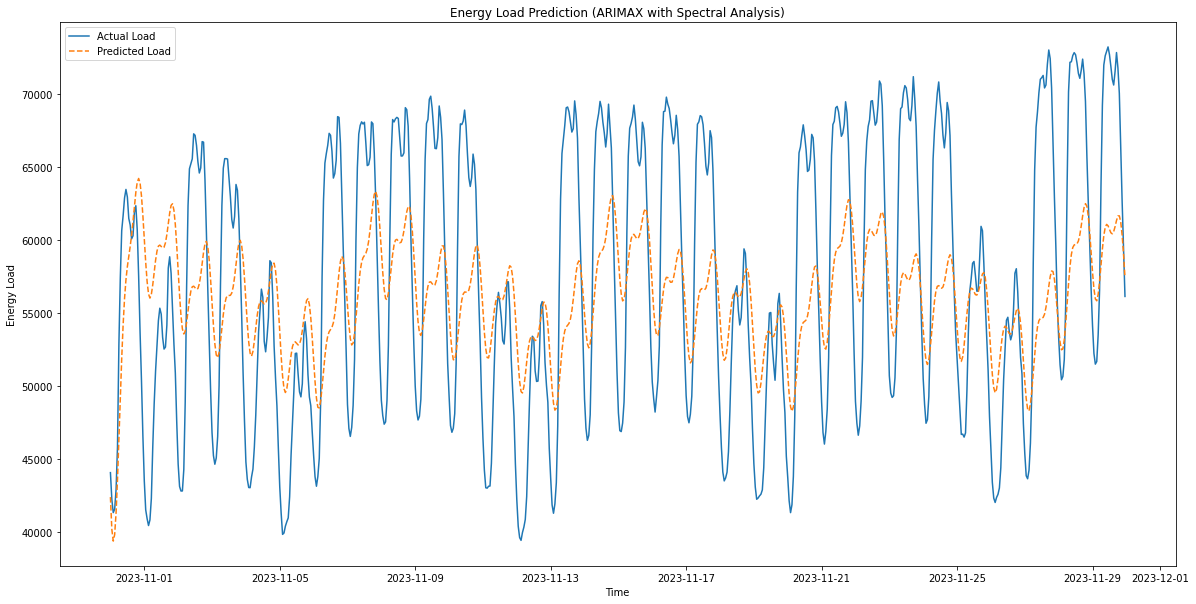

In [56]:
#Plot only one month
start = 0
end = 720

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

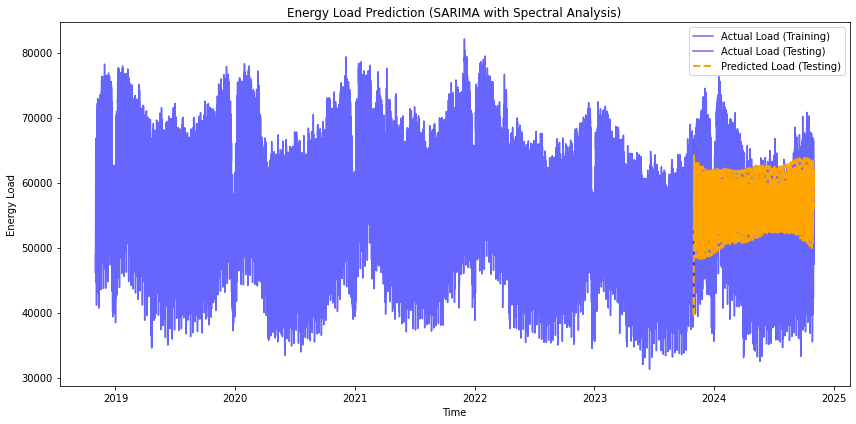

In [58]:
# Plot actual vs predicted energy load for the whole dataset (train + test) and predictions
plt.figure(figsize=(12, 6))

# Plot the actual load for the training and testing set
plt.plot(df.index[:train_size], y_train, label='Actual Load (Training)', color='blue', alpha=0.6)
plt.plot(df.index[train_size:], y_test, label='Actual Load (Testing)', color='blue', alpha=0.6)

# Plot the predicted load (only for the test period)
plt.plot(test.index, forecast, label='Predicted Load (Testing)', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (SARIMA with Spectral Analysis)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()